### Throw / Gravity predictor

A small test project for RNNs in Keras. Simulates a thrown ball with a parabola curve and bounces from the ground and tries to predict it.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing
import os
import matplotlib.pyplot as plt
import math
from livelossplot import PlotLossesKeras

/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

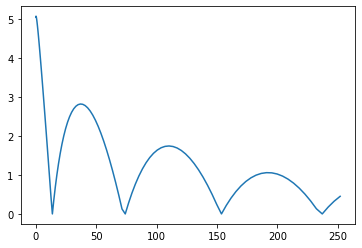

In [2]:
def generate_throw(start_height, throw_speed_x, throw_speed_y, resolution, points, bounce=True):
    x = 0
    y = start_height
    vx = throw_speed_x
    vy = throw_speed_y
    
    result = np.ndarray(shape=(points, 4))
    
    for step in range(points):
        x += vx * resolution
        y += vy * resolution
        vx += 0.95 ** resolution
        vy -= 9.81 * resolution
        
        if y <= 0 and bounce:
            y = 0
            vy *= -0.7
        
        result[step, :] = [x, y, vx, vy]
    
    return result

throw = generate_throw(5, 1, 1, 0.05, 100)
plt.plot(throw[:, 0], throw[:, 1])

(60, 40, 2) (60, 2)


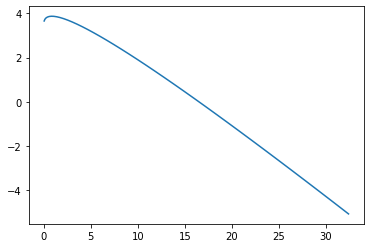

In [3]:
# Generates a specified amount of data using the "generate_throw" function.
# A throw of random length is generated and sub-sampled for the specified time length.
# This is repeated until the desired size is met.
# Return values are X and y, where X has shape (n_steps, series_length, 2) and y has shape (n_steps, 4).
# n_steps = n_throws * (throw_length - series_length)
def generate_data(n_throws, throw_length, series_length, bounce=True):
    n_steps = n_throws * (throw_length - series_length)
    X = np.ndarray(shape=(n_steps, series_length, 2))
    y = np.ndarray(shape=(n_steps, 2))
    
    i = 0
    for k in range(n_throws):
        
        h = np.random.rand() * 10
        vx = abs(np.random.randn())
        vy = np.random.rand() * 5
        
        throw = generate_throw(h, vx, vy, 4 / throw_length, throw_length, bounce=bounce)
        for l in range(throw_length - series_length):
            X[i, :, :] = throw[l:l+series_length, 0:2]
            y[i, :] = throw[l + series_length, 0:2]
            i += 1
    
    return X, y

X, y = generate_data(1, 100, 40, bounce=False)
print(X.shape, y.shape)
plt.plot(X[0, :, 0], X[0, :, 1])

In [41]:
SERIES_LENGTH = 40

X_train, y_train = generate_data(200, 100, SERIES_LENGTH, bounce=False)
X_test, y_test = generate_data(20, 100, SERIES_LENGTH, bounce=False)

X_train = X_train[:, :, 1:2]
y_train = y_train[:, 1:2]
X_test = X_test[:, :, 1:2]
y_test = y_test[:, 1:2]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12000, 40, 1) (12000, 1) (1200, 40, 1) (1200, 1)


In [48]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(-1, SERIES_LENGTH, 1)
y_train = scaler.transform(y_train)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(-1, SERIES_LENGTH, 1)
y_test = scaler.transform(y_test)

X_train[0, :, 0]

array([0.93667666, 0.93641244, 0.9357807 , 0.93478144, 0.93341465,
       0.93168034, 0.92957852, 0.92710917, 0.92427229, 0.9210679 ,
       0.91749599, 0.91355655, 0.9092496 , 0.90457512, 0.89953312,
       0.8941236 , 0.88834656, 0.88220199, 0.87568991, 0.8688103 ,
       0.86156317, 0.85394852, 0.84596635, 0.83761666, 0.82889945,
       0.81981471, 0.81036246, 0.80054268, 0.79035538, 0.77980056,
       0.76887822, 0.75758836, 0.74593097, 0.73390607, 0.72151364,
       0.70875369, 0.69562622, 0.68213123, 0.66826871, 0.65403868])

### Create simple model

In [49]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.4, return_sequences=True))
model.add(keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.4))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='tanh'))

model.build((None, SERIES_LENGTH, 1))

model.compile(
    optimizer='adam',
    loss='mae')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 40, 64)            16896     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
__________________________________________________

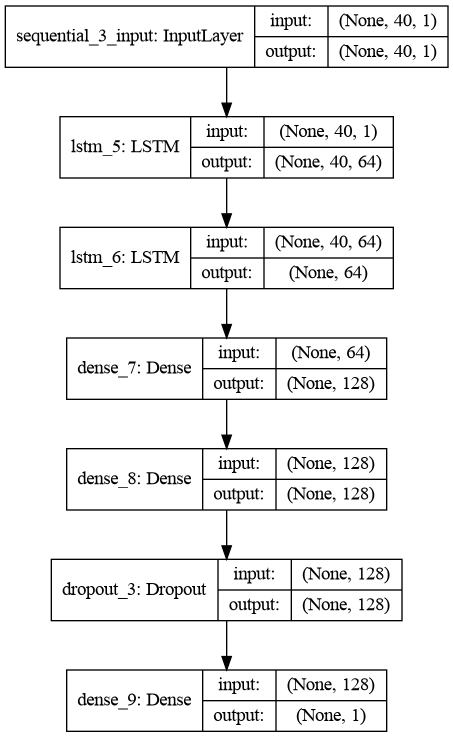

In [50]:
from IPython.display import Image
import pydot

keras.utils.plot_model(model, to_file=f'modelplot.png', show_shapes=True)

Image(f'modelplot.png')

In [52]:
y_train.shape

(12000, 1)

In [53]:
hist = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=256,
)

Train on 12000 samples, validate on 1200 samples
Epoch 1/50
12000/12000 [==============================] - 10s 793us/step - loss: 0.1806 - val_loss: 0.0714
Epoch 2/50
12000/12000 [==============================] - 7s 608us/step - loss: 0.1186 - val_loss: 0.0744
Epoch 3/50
12000/12000 [==============================] - 7s 621us/step - loss: 0.1127 - val_loss: 0.0912
Epoch 4/50
12000/12000 [==============================] - 7s 623us/step - loss: 0.1036 - val_loss: 0.0929
Epoch 5/50
12000/12000 [==============================] - 8s 636us/step - loss: 0.0894 - val_loss: 0.0963
Epoch 6/50
12000/12000 [==============================] - 7s 614us/step - loss: 0.0812 - val_loss: 0.0829
Epoch 7/50
12000/12000 [==============================] - 7s 612us/step - loss: 0.0730 - val_loss: 0.0730
Epoch 8/50
12000/12000 [==============================] - 7s 619us/step - loss: 0.0703 - val_loss: 0.0814
Epoch 9/50
12000/12000 [==============================] - 7s 619us/step - loss: 0.0680 - val_loss: 0.0

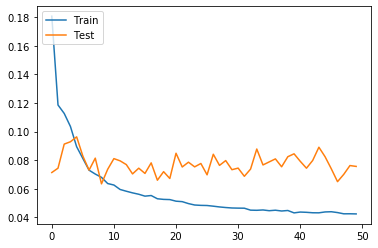

In [55]:
val_loss = hist.history['val_loss']
loss = hist.history['loss']

plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Train', 'Test',], loc='upper left')

### Testing

In [63]:
X_play, y_play = X_train, y_train

i = np.random.randint(0, len(X_play))

X = X_play[i]
y_hat = y_play[i].reshape(1, -1)

y_pred = model.predict(X.reshape(1, SERIES_LENGTH, 1))

y_hat, y_pred

(array([[-0.81422104]]), array([[-0.69123006]], dtype=float32))

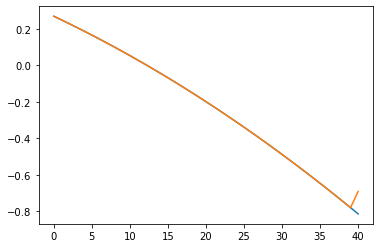

In [64]:
prediction_y = np.concatenate([X, y_pred]).reshape(-1)
truth = np.concatenate([X, y_hat])
truth_y = truth

plt.plot(truth_y)
plt.plot(prediction_y)

### Multi-Prediction

In [58]:
X = X_test[60]
for i in range(60):
    y_pred = model.predict(X[-SERIES_LENGTH:, :].reshape(1, SERIES_LENGTH, 2))
    x = X[-1, 0]*2 - X[-2, 0]
    col = np.array([x, y_pred]).reshape(1, 2)
    X = np.concatenate([X, col])
    
plt.plot(X[:, 0], X[:, 1])

ValueError: cannot reshape array of size 40 into shape (1,40,2)